In [ ]:
import torch
import torchvision.models as models

# Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)
# Freeze all the pre-trained layers
for param in model.parameters():
    param.requires_grad = True
num_classes = 10 # replace with the number of classes in your dataset
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 150MB/s]


In [ ]:
import os
import tarfile
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import DataLoader

# Set the root directory for your custom dataset
custom_dataset_root = "./"

# Download and extract CIFAR-10 dataset
cifar10_train = CIFAR10(root=custom_dataset_root, train=True, download=True, transform=transforms.ToTensor())
cifar10_test = CIFAR10(root=custom_dataset_root, train=False, download=True, transform=transforms.ToTensor())


# Define the transformations to apply to the images
transform = transforms.Compose([
    transforms.ToTensor(),
])


100%|██████████| 170498071/170498071 [00:01<00:00, 102342978.17it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [ ]:
from torch.utils.data import DataLoader

# Create data loaders for the train and validation datasets
train_loader = DataLoader(cifar10_train, batch_size=5, shuffle=True)
val_loader = DataLoader(cifar10_test, batch_size=32, shuffle=False)


In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/modelweights.pth'))

<All keys matched successfully>

In [ ]:
batch = next(iter(train_loader))

In [ ]:
batch[1]

tensor([2, 7, 9, 1, 0])

In [ ]:
import cv2
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from torch.autograd import Variable
from torch.nn import functional as F
from tqdm import tqdm


class SmoothGrad(object):

    def __init__(self, model, sigma, n_samples, guided= False):
        self.model = model
        self.model.eval()

        self.sigma = sigma
        self.n_samples = n_samples

    def load_image(self, filename):
        self.image = Variable(filename, volatile=False, requires_grad=True)

    def forward(self):
        self.preds = self.model(self.image)
        self.probs = F.softmax(self.preds)[0]
        self.prob, self.idx = self.probs.data.sort(0, True)
        return self.prob, self.idx

    def encode_one_hot(self, idx):
        one_hot = torch.FloatTensor(1, self.probs.size()[-1]).zero_()
        one_hot[0][idx] = 1.0
        return one_hot

    def backward(self, idx):
        # Compute the gradients wrt the specific class
        self.model.zero_grad()
        one_hot = self.encode_one_hot(idx)
        self.preds.backward(gradient=one_hot, retain_graph=True)

    def generate(self, idx):
        grads = []
        image = self.image.data.cpu()
        sigma = (image.max() - image.min()) * self.sigma

        for i in tqdm(range(self.n_samples)):
            # Add gaussian noises
            noised_image = image + torch.randn(image.size()) * sigma
            self.image = Variable(
                noised_image, volatile=False, requires_grad=True)
            self.forward()
            self.backward(idx=idx)

            # Sample the gradients on the pixel-space
            grad = self.image.grad.data.cpu().numpy()
            grads.append(grad)

        grad = np.mean(np.array(grads), axis=0)
        saliency = np.max(np.abs(grad), axis=1)[0]
        saliency -= saliency.min()
        saliency /= saliency.max()
        saliency = np.uint8(saliency * 255)
        cv2.imwrite( '_{:04d}.png'.format(i), saliency)

        self.model.zero_grad()
        return saliency

  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-42-63f7f6ca960c>:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.probs = F.softmax(self.preds)[0]
100%|██████████| 50/50 [00:01<00:00, 31.82it/s]


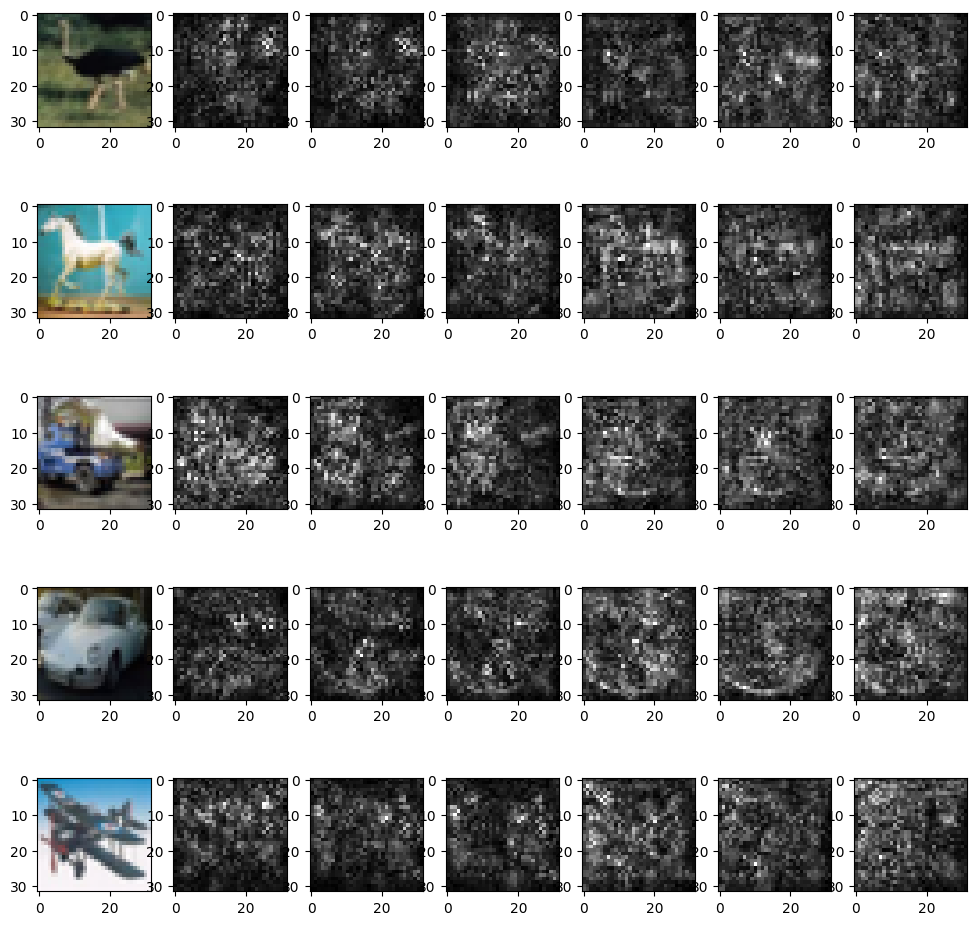

In [ ]:
import matplotlib.pyplot as plt

n_samples = 50
sigma = [0, 0.05, 0.1, 0.2, 0.3, 0.5]
fig, axes = plt.subplots(5, len(sigma)+1, figsize=(12, 12))

for i in (range(batch[0].shape[0])):
  axes[i, 0].imshow(batch[0][i].permute(1, 2, 0))
  for j, sigma_ in enumerate(sigma):
    smooth_grad = SmoothGrad(model=model, sigma=sigma_,
                                n_samples=n_samples)

    smooth_grad.load_image(batch[0][i].unsqueeze(0))
    # Predict without adding noises
    grads = smooth_grad.generate(batch[1][i])
    axes[i, j+1].imshow(grads ,  cmap='gray')
plt.show()